In [42]:
# compute
import numpy as np

# interpolation and triangulation
import scipy.interpolate
import scipy.spatial
import matplotlib.tri

# colormapping
import matplotlib.cm
import matplotlib.colors

import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
xyz = np.loadtxt('/Users/baart_f/Downloads/6650x5000, zonder zandmotor (2).xyz')

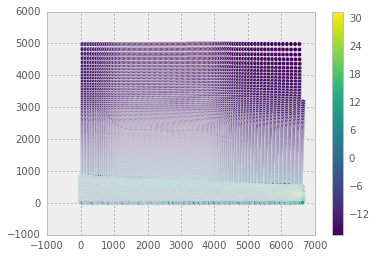

In [29]:
plt.scatter(xyz[:,0], xyz[:,1], c=xyz[:,2], cmap='viridis')
plt.colorbar()

In [32]:
# we need a few extra points around the edge so we know that we have a square
# define an interpolation function
L = scipy.interpolate.NearestNDInterpolator(xyz[:,:2], xyz[:,2])
xmin = xyz[:,0].min()
xmax = xyz[:,0].max()
ymin = xyz[:,1].min()
ymax = xyz[:,1].max()

Y, X = np.mgrid[(ymin-20):(ymax+20):200, (xmin-20):(xmax+20):2j]
xy_extra = np.c_[X.ravel(), Y.ravel()]
# create a xyz
xyz_extra = np.hstack((xy_extra, L(xy_extra)[:,np.newaxis]))
# append to xyz
xyz = np.vstack((xyz, xyz_extra))
Y, X = np.mgrid[(ymin-20):(ymax+20):2j, (xmin-20):(xmax+20):200]
xy_extra = np.c_[X.ravel(), Y.ravel()]
# create xyz
xyz_extra = np.hstack((xy_extra, L(xy_extra)[:,np.newaxis]))
# append to xyz
xyz = np.vstack((xyz, xyz_extra))


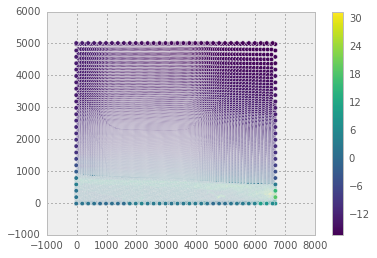

In [33]:
# now we have a regular outer boundary
plt.scatter(xyz[:,0], xyz[:,1], c=xyz[:,2], cmap='viridis')
plt.colorbar()

In [40]:
# define a triangular mesh
tri = matplotlib.tri.Triangulation(xyz[:,0], xyz[:,1])


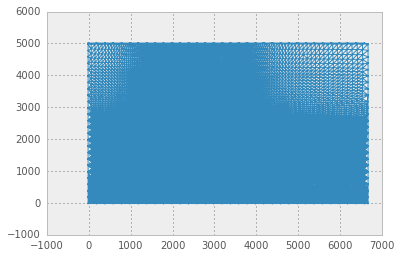

In [35]:
# this should look somewhat regular, it's the basis for the mesh
_ = plt.triplot(tri)

In [41]:
# convert from world to engineering coordinates (our local sandbox)
# also cleanup and rescale vertical > 0 different from vertical < 0
def x2bak(x):
    # from 6650m to 1.33m
    result = (x/6650.0)*1.33
    return result
def y2bak(y):
    # from 0,5000 to 1m
    result = (y/5000.0)*1.0
    return result
def z2bak(z):
    # chop
    z[z < -12] = -12
    z[z > 0] *= 0.5
    z[z > 12] = 12
    
    # raise to 0
    z -= -12
    # from 0,24 to 0.20
    result = (z/24.0)*0.2
    return result
xyz_scaled = np.c_[
    x2bak(xyz[:,0].copy()),
    y2bak(xyz[:,1].copy()),
    z2bak(xyz[:,2].copy())
]

In [43]:
# rescale z to 0,1 for computing colors
N = matplotlib.colors.Normalize(xyz[:,2].min(), xyz[:,2].max())

In [44]:
# see https://github.com/dranjan/python-plyfile
# compute vertex array (bit of hack with the tulpes)
vertex = np.array([
        tuple(row) 
        for row
        in xyz_scaled.tolist()
    ], dtype=[
        ('x', 'f4'),
        ('y', 'f4'),
        ('z', 'f4')
    ])

# create a list of tuples followed by red,green,blue
facelist = []
for triangle in tri.triangles:
    z_triangle = xyz[triangle[0], 2]
    r, g, b, a = matplotlib.cm.gist_earth(N(z_triangle), bytes=True)
    facelist.append((triangle, r, g, b))
    
face = np.array(facelist,
                dtype=[
        ('vertex_indices', 'i4', (3,)),
        ('red', 'u1'), ('green', 'u1'),
        ('blue', 'u1')
    ])


In [45]:
import plyfile

ply = plyfile.PlyData([
        plyfile.PlyElement.describe(
                vertex, 'vertex',
                comments=['tetrahedron vertices']
        ),
        plyfile.PlyElement.describe(face, 'face')
    ],
    text=True, 
    byte_order='=',
    comments=['single tetrahedron with colored faces']
)
ply.write('filename.ply')
